In [1]:
pip install pandas numpy matplotlib scikit-learn


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# --- Импорты ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
# --- 1. Загружаем данные ---
# (замени путь на свой, если файл в другом месте)
df = pd.read_csv("health_fitness_dataset.csv")

In [4]:
# --- 2. Отбираем признаки ---
features = ['weight_kg', 'avg_heart_rate', 'daily_steps', 'calories_burned', 'hours_sleep']
X = df[features]

In [13]:
# --- 3. Создаём метки для supervised: хотя бы два признака вне нормы ---
conditions = [
    df['avg_heart_rate'] > 110,   # высокий пульс
    df['hours_sleep'] < 5,        # мало сна
    df['daily_steps'] < 3000,     # низкая активность
    df['calories_burned'] < 1000 # мало калорий
]

df['num_violations'] = np.sum(conditions, axis=0)
df['label'] = (df['num_violations'] >= 2).astype(int)

y = df['label']

print("Label distribution:\n", y.value_counts())

Label distribution:
 label
1    606087
0     81614
Name: count, dtype: int64


In [14]:
# --- 4. Unsupervised: Isolation Forest ---
iso = IsolationForest(contamination=0.1, random_state=42)
unsupervised_preds = iso.fit_predict(X)
unsupervised_scores = iso.decision_function(X)

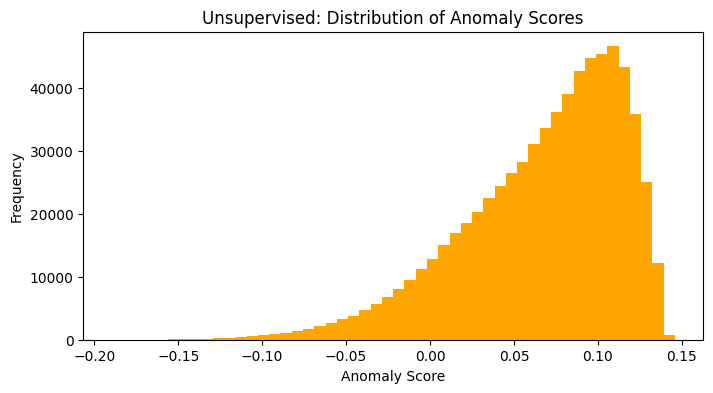


Примеры предсказаний Unsupervised:
      Score  Prediction
0  0.007232           1
1 -0.013056          -1
2  0.022772           1
3  0.057354           1
4  0.018972           1
5  0.071033           1
6  0.021812           1
7  0.024791           1
8  0.044922           1
9  0.020890           1


In [15]:
# --- Визуализация Unsupervised ---
plt.figure(figsize=(8,4))
plt.hist(unsupervised_scores, bins=50, color='orange')
plt.title("Unsupervised: Distribution of Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.show()

print("\nПримеры предсказаний Unsupervised:")
print(pd.DataFrame({'Score': unsupervised_scores[:10], 'Prediction': unsupervised_preds[:10]}))

In [16]:
# --- 5. Supervised: RandomForestClassifier ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# --- Безопасная обработка predict_proba ---
if len(clf.classes_) == 2:
    y_proba = clf.predict_proba(X_test)[:, 1]  # вероятность аномалии
else:
    y_proba = np.ones_like(y_test, dtype=float)  # случай одного класса

print("\n=== Supervised Classification Report ===")
print(classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


=== Supervised Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16323
           1       1.00      1.00      1.00    121218

    accuracy                           1.00    137541
   macro avg       1.00      1.00      1.00    137541
weighted avg       1.00      1.00      1.00    137541

Confusion matrix:
 [[ 16323      0]
 [     0 121218]]


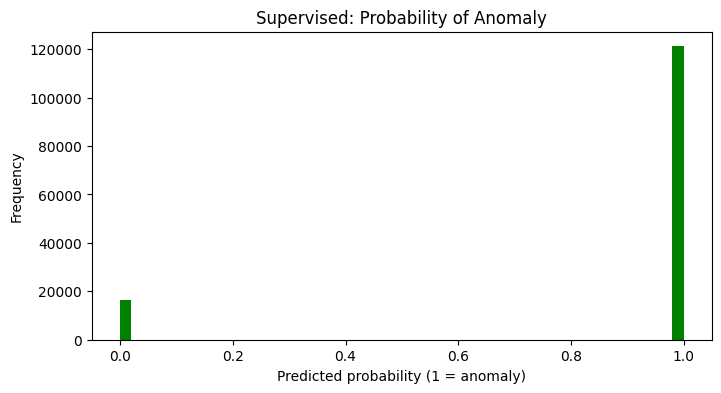

In [17]:
# --- Визуализация вероятностей ---
plt.figure(figsize=(8,4))
plt.hist(y_proba, bins=50, color='green')
plt.title("Supervised: Probability of Anomaly")
plt.xlabel("Predicted probability (1 = anomaly)")
plt.ylabel("Frequency")
plt.show()

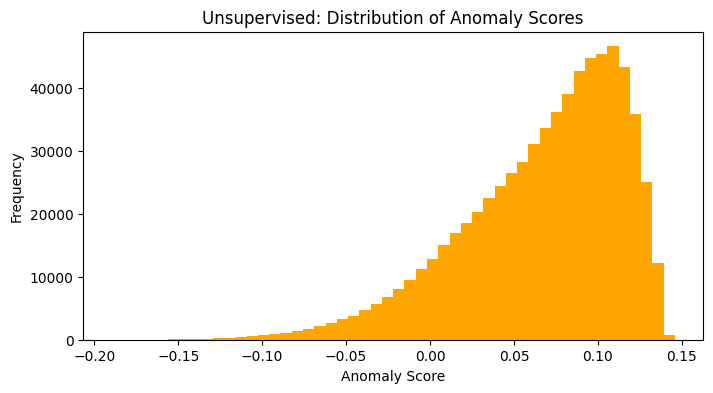


=== Unsupervised (IsolationForest) Classification Report ===
              precision    recall  f1-score   support

           0       0.12      0.89      0.21     81614
           1       0.87      0.10      0.18    606087

    accuracy                           0.19    687701
   macro avg       0.49      0.49      0.19    687701
weighted avg       0.78      0.19      0.18    687701

Confusion matrix:
 [[ 72517   9097]
 [546414  59673]]

=== Comparison of Approaches (first 10 rows) ===
   unsupervised_pred  supervised_pred  true_label
0                  0                0           0
1                  1                0           0
2                  0                1           1
3                  0                1           1
4                  0                1           1
5                  0                1           1
6                  0                1           1
7                  0                0           0
8                  0                1           1
9      

In [18]:
# --- 4. Unsupervised: Isolation Forest (повторно на новом X) ---
iso = IsolationForest(contamination=0.1, random_state=42)
unsupervised_preds = iso.fit_predict(X)
unsupervised_scores = iso.decision_function(X)

# IsolationForest возвращает: 1 = норма, -1 = аномалия
# Преобразуем к 0/1 для удобного сравнения
unsupervised_binary = (unsupervised_preds == -1).astype(int)

# --- Визуализация Unsupervised ---
plt.figure(figsize=(8,4))
plt.hist(unsupervised_scores, bins=50, color='orange')
plt.title("Unsupervised: Distribution of Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.show()

# --- Сравнение с supervised ---
comparison_df = pd.DataFrame({
    'unsupervised_pred': unsupervised_binary,
    'supervised_pred': clf.predict(X),
    'true_label': y
})

# --- Метрики для IsolationForest ---
from sklearn.metrics import classification_report, confusion_matrix

print("\n=== Unsupervised (IsolationForest) Classification Report ===")
print(classification_report(y, unsupervised_binary))
print("Confusion matrix:\n", confusion_matrix(y, unsupervised_binary))

# --- Сравнение предсказаний на первых 10 примерах ---
print("\n=== Comparison of Approaches (first 10 rows) ===")
print(comparison_df.head(10))



=== Training RandomForest ===

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16323
           1       1.00      1.00      1.00    121218

    accuracy                           1.00    137541
   macro avg       1.00      1.00      1.00    137541
weighted avg       1.00      1.00      1.00    137541

Confusion matrix:
 [[ 16323      0]
 [     0 121218]]
ROC AUC: 1.0000

=== Training GradientBoosting ===

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16323
           1       1.00      1.00      1.00    121218

    accuracy                           1.00    137541
   macro avg       1.00      1.00      1.00    137541
weighted avg       1.00      1.00      1.00    137541

Confusion matrix:
 [[ 16323      0]
 [     0 121218]]
ROC AUC: 1.0000

=== Training LogisticRegression ===

Classification report:
              precision    reca

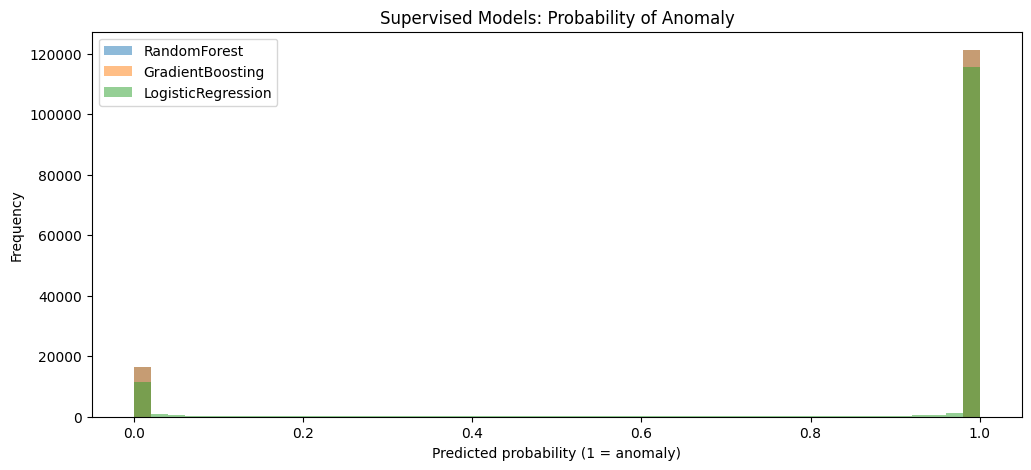

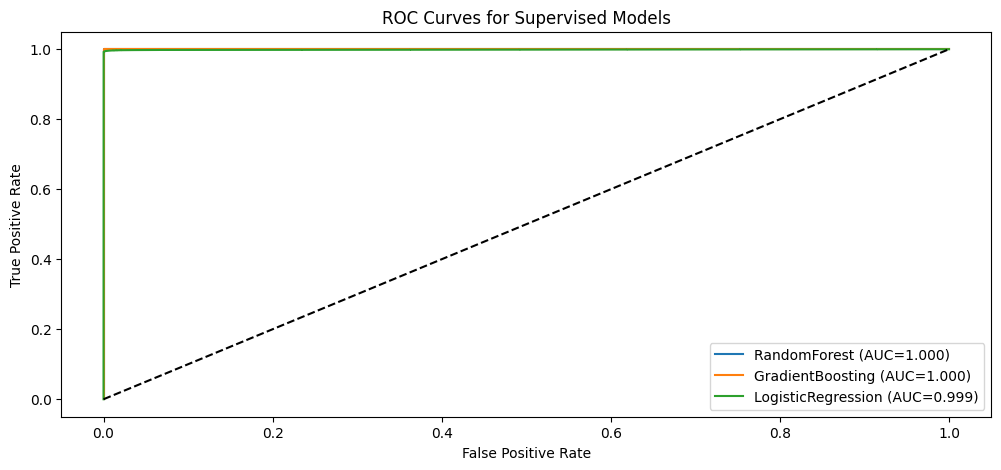


=== First 10 predictions for all models ===
   RandomForest_pred  GradientBoosting_pred  LogisticRegression_pred  \
0                  1                      1                        1   
1                  1                      1                        1   
2                  1                      1                        1   
3                  1                      1                        1   
4                  1                      1                        1   
5                  1                      1                        1   
6                  1                      1                        1   
7                  1                      1                        1   
8                  1                      1                        1   
9                  1                      1                        1   

   true_label  
0           1  
1           1  
2           1  
3           1  
4           1  
5           1  
6           1  
7           1  
8           1  
9 

In [22]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# --- Словарь моделей ---
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42)
}

# --- Словарь для хранения результатов ---
results = {}

# --- Обучение и предсказания ---
for name, model in models.items():
    print(f"\n=== Training {name} ===")
    
    # обучение
    model.fit(X_train, y_train)
    
    # предсказания классов
    y_pred = model.predict(X_test)
    
    # предсказанные вероятности аномалии
    if hasattr(model, "predict_proba") and len(model.classes_) == 2:
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = np.ones_like(y_test, dtype=float)
    
    # метрики
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    
    # ROC AUC
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"ROC AUC: {roc_auc:.4f}")
    
    # сохраняем результаты
    results[name] = {
        "model": model,
        "y_pred": y_pred,
        "y_proba": y_proba,
        "roc_auc": roc_auc
    }

# --- Визуализация распределения вероятностей ---
plt.figure(figsize=(12,5))
for name, res in results.items():
    plt.hist(res['y_proba'], bins=50, alpha=0.5, label=name)
plt.title("Supervised Models: Probability of Anomaly")
plt.xlabel("Predicted probability (1 = anomaly)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# --- Визуализация ROC-кривых ---
plt.figure(figsize=(12,5))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['y_proba'])
    plt.plot(fpr, tpr, label=f"{name} (AUC={res['roc_auc']:.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Supervised Models")
plt.legend()
plt.show()

# --- Сравнение первых 10 предсказаний ---
comparison_df = pd.DataFrame({
    name + "_pred": res['y_pred'] for name, res in results.items()
})
comparison_df['true_label'] = y_test.reset_index(drop=True)
print("\n=== First 10 predictions for all models ===")
print(comparison_df.head(10))


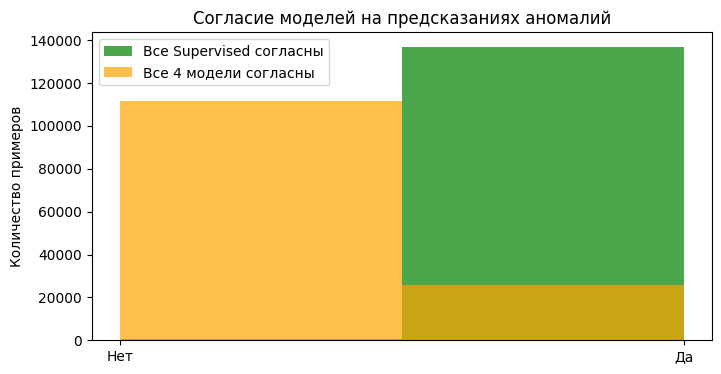


=== Первые 10 предсказаний всех моделей ===
   RandomForest  GradientBoosting  LogisticRegression  IsolationForest  \
0             1                 1                   1                0   
1             1                 1                   1                0   
2             1                 1                   1                0   
3             1                 1                   1                0   
4             1                 1                   1                0   
5             1                 1                   1                0   
6             1                 1                   1                0   
7             1                 1                   1                1   
8             1                 1                   1                0   
9             1                 1                   1                0   

   true_label  all_supervised_agree  all_models_agree  
0           1                     1                 0  
1           1               

In [24]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# --- 1. Обучение IsolationForest ---
iso = IsolationForest(contamination=0.1, random_state=42)
iso_preds = iso.fit_predict(X)
# Преобразуем в 0/1 (1 = аномалия)
iso_binary = (iso_preds == -1).astype(int)

# --- 2. Создаём DataFrame для сравнения ---
# Предсказания IsolationForest на X_test
iso_test_preds = iso.predict(X_test)
iso_binary_test = (iso_test_preds == -1).astype(int)

# DataFrame для сравнения на тестовой выборке
comparison_df = pd.DataFrame({
    'RandomForest': results['RandomForest']['y_pred'],
    'GradientBoosting': results['GradientBoosting']['y_pred'],
    'LogisticRegression': results['LogisticRegression']['y_pred'],
    'IsolationForest': iso_binary_test,
    'true_label': y_test.reset_index(drop=True)
})


# --- 3. Считаем согласие моделей ---
comparison_df['all_supervised_agree'] = (
    (comparison_df['RandomForest'] == comparison_df['GradientBoosting']) &
    (comparison_df['RandomForest'] == comparison_df['LogisticRegression'])
).astype(int)

comparison_df['all_models_agree'] = (
    (comparison_df['all_supervised_agree'] == 1) &
    (comparison_df['RandomForest'] == comparison_df['IsolationForest'])
).astype(int)

# --- 4. Визуализация распределения согласия ---
plt.figure(figsize=(8,4))
plt.hist(comparison_df['all_supervised_agree'], bins=2, color='green', alpha=0.7, label='Все Supervised согласны')
plt.hist(comparison_df['all_models_agree'], bins=2, color='orange', alpha=0.7, label='Все 4 модели согласны')
plt.xticks([0,1], ['Нет', 'Да'])
plt.title("Согласие моделей на предсказаниях аномалий")
plt.ylabel("Количество примеров")
plt.legend()
plt.show()

# --- 5. Примеры первых 10 строк ---
print("\n=== Первые 10 предсказаний всех моделей ===")
print(comparison_df.head(10))
